# Fossil Demand Forecasting Challenge
# By Mohamed Eltayeb

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

# Define Some Functions

In [2]:
#Plot the LGBM Features Importances
def plotImp(model, X , num = 30, fig_size = (60, 30)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [3]:
#Reduce Memory Usage
def reduce_memory_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    
    return df

# Read the training and testing data


In [4]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

## Sort The Values Based on Time

In [5]:
train_df = train_df.sort_values(['sku_name','year','month']).reset_index(drop=True) 
test_df = test_df.sort_values(['sku_name','year','month']).reset_index(drop=True)

## Store IDs

In [6]:
ID = test_df['sku_name'] + '_' + test_df['month'].astype(str) + '_' + test_df['year'].astype(str)

# EDA

In [7]:
train_df.shape

(44907, 45)

In [8]:
test_df.shape

(1528, 6)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44907 entries, 0 to 44906
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sku_name                     44907 non-null  object 
 1   starting_inventory           44907 non-null  int64  
 2   sellin                       44907 non-null  int64  
 3   sellin_channel_1             44907 non-null  int64  
 4   sellin_channel_2             44907 non-null  int64  
 5   sellin_channel_3             44907 non-null  int64  
 6   sellin_channel_4             44907 non-null  int64  
 7   sellin_channel_5             44907 non-null  int64  
 8   sellin_channel_6             44907 non-null  int64  
 9   sellin_channel_7             44907 non-null  int64  
 10  sellin_channel_8             44907 non-null  int64  
 11  sellout                      44907 non-null  int64  
 12  onhand_inventory             44907 non-null  int64  
 13  leftover_invento

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sku_name          1528 non-null   object
 1   month             1528 non-null   int64 
 2   year              1528 non-null   int64 
 3   CAT_GENDER_BOTH   1528 non-null   int64 
 4   CAT_GENDER_MEN    1528 non-null   int64 
 5   CAT_GENDER_WOMEN  1528 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 71.8+ KB


In [11]:
train_df.head()

,sku_name,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,sellin_channel_6,sellin_channel_7,sellin_channel_8,sellout,onhand_inventory,leftover_inventory,sellout_channel_1,sellout_channel_2,sellout_channel_3,sellout_channel_4,sellout_channel_5,sellout_channel_6,sellout_channel_7,sellout_channel_8,sellout_channel_9,sellout_channel_10,onhand_inventory_channel_1,onhand_inventory_channel_2,onhand_inventory_channel_3,onhand_inventory_channel_4,onhand_inventory_channel_5,onhand_inventory_channel_6,onhand_inventory_channel_7,onhand_inventory_channel_8,onhand_inventory_channel_9,onhand_inventory_channel_10,price,month,year,product_lifecycle_stage,FLAG100,disc_month,cum_disc,CAT_GENDER_BOTH,CAT_GENDER_MEN,CAT_GENDER_WOMEN,Weeks
0,ABEAHAMASHL,6844841,902583,542968,236029,34442,0,14182,5065,9117,0,421408,4081377,481175,226912,82053,43559,0,11143,1013,29377,0,16208,11143,2346108,512578,670606,5065,57741,0,148911,0,229951,110417,145,1,2016,M,0.013,0,0,0,0,1,1
1,ABEAHAMASHL,6679722,358602,208678,98261,18234,0,0,3039,6078,0,468006,3970960,-109404,278575,88131,39507,0,10130,3039,34442,0,8104,6078,2299510,508526,640216,5065,42546,0,135742,0,232990,106365,145,2,2016,M,0.000,0,0,0,0,1,0
2,ABEAHAMASHL,6462940,1177106,306939,263380,44572,1013,455850,4052,79014,0,473071,3553604,704035,236029,66858,68884,2026,17221,3039,52676,0,15195,11143,2226574,394057,434577,4052,53689,0,117508,0,225899,97248,145,3,2016,M,0.000,0,0,0,0,1,0
3,ABEAHAMASHL,5217963,968428,314030,237042,22286,2026,324160,4052,1013,0,448759,3381394,519669,260341,66858,34442,1013,7091,4052,59767,0,3039,12156,2172885,442681,409252,5065,42546,0,87118,0,132703,89144,145,4,2016,M,0.000,0,0,0,0,1,0
4,ABEAHAMASHL,4785412,470032,208678,187405,16208,5065,6078,5065,16208,0,552085,3310484,-82053,277562,169171,32416,-1013,9117,3039,48624,0,4052,9117,2012831,558163,387979,9117,37481,0,120547,0,91170,93196,145,5,2016,M,0.000,0,0,0,0,1,1


In [12]:
test_df.head()

,sku_name,month,year,CAT_GENDER_BOTH,CAT_GENDER_MEN,CAT_GENDER_WOMEN
0,ABEAHAMASHL,11,2021,0,0,1
1,ABEAHAMASHL,12,2021,0,0,1
2,ABEAHAMASHL,1,2022,0,0,1
3,ABEAHAMASHL,2,2022,0,0,1
4,ABEENNEARMAZZ,11,2021,0,0,1


In [13]:
train_df.describe()

,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,sellin_channel_6,sellin_channel_7,sellin_channel_8,sellout,onhand_inventory,leftover_inventory,sellout_channel_1,sellout_channel_2,sellout_channel_3,sellout_channel_4,sellout_channel_5,sellout_channel_6,sellout_channel_7,sellout_channel_8,sellout_channel_9,sellout_channel_10,onhand_inventory_channel_1,onhand_inventory_channel_2,onhand_inventory_channel_3,onhand_inventory_channel_4,onhand_inventory_channel_5,onhand_inventory_channel_6,onhand_inventory_channel_7,onhand_inventory_channel_8,onhand_inventory_channel_9,onhand_inventory_channel_10,price,month,year,FLAG100,disc_month,cum_disc,CAT_GENDER_BOTH,CAT_GENDER_MEN,CAT_GENDER_WOMEN,Weeks
count,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000,44907.000
mean,364829.671,246953.280,130760.464,33968.288,23096.612,14840.618,9593.848,8523.664,7648.266,5769.433,148707.349,735567.752,98245.931,77132.550,11423.054,18712.066,18580.509,6575.827,5870.446,3618.982,569.041,1649.399,4575.475,402567.084,68234.089,103778.711,64078.166,34814.203,0.000,15723.483,3470.687,10724.554,32186.407,138.975,6.495,2017.873,0.050,0.123,0.275,0.013,0.448,0.539,0.344
std,1307197.258,539603.778,367145.760,101688.204,66181.589,101873.550,42555.114,30720.361,40969.644,40924.526,344635.124,1264807.804,389690.375,257644.603,27525.403,40289.321,87050.915,17649.687,24254.911,13136.471,1649.035,6567.872,11208.507,906936.839,131981.092,164539.866,207602.322,76623.437,0.000,49433.897,7128.146,38132.615,62467.188,35.100,3.356,1.626,0.129,0.329,0.446,0.112,0.497,0.498,0.475
min,0.000,-1013.000,0.000,0.000,0.000,0.000,0.000,-1013.000,0.000,0.000,-67871.000,-17221.000,-9177780.000,-7091.000,-9117.000,-27351.000,-6078.000,-1013.000,-69897.000,-1013.000,-2026.000,-2026.000,-8104.000,-1013.000,0.000,-71923.000,-17221.000,0.000,0.000,0.000,0.000,0.000,-2026.000,45.000,1.000,2016.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,2026.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5065.000,29377.000,-18234.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1013.000,0.000,0.000,0.000,0.000,0.000,0.000,115.000,4.000,2016.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,22286.000,1013.000,0.000,0.000,0.000,0.000,1013.000,0.000,0.000,36468.000,210704.000,0.000,2026.000,0.000,0.000,1013.000,1013.000,1013.000,0.000,0.000,0.000,0.000,19247.000,3039.000,4052.000,4052.000,9117.000,0.000,0.000,0.000,0.000,3039.000,135.000,6.000,2018.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
75%,1013.000,234003.000,65845.000,10130.000,15195.000,2026.000,0.000,7091.000,0.000,0.000,148911.000,852946.000,74962.000,48624.000,7091.000,23299.000,5065.000,5065.000,5065.000,0.000,0.000,0.000,4052.000,328718.500,60780.000,177275.000,12156.000,30390.000,0.000,2026.000,4052.000,3039.000,32416.000,155.000,10.000,2019.000,0.038,0.000,1.000,0.000,1.000,1.000,1.000
max,22385274.000,11396250.000,10193819.000,3211210.000,1378693.000,3448252.000,876245.000,1737295.000,3096741.000,1499240.000,16346781.000,16884684.000,7865945.000,15825086.000,503461.000,976532.000,3489785.000,390005.000,1649164.000,255276.000,53689.000,245146.000,309978.000,15231468.000,1145703.000,1343238.000,3321627.000,787101.000,0.000,1041364.000,95222.000,715178.000,696944.000,500.000,12.000,2021.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [14]:
test_df.describe()

,month,year,CAT_GENDER_BOTH,CAT_GENDER_MEN,CAT_GENDER_WOMEN
count,1528.000,1528.000,1528.000,1528.000,1528.000
mean,6.500,2021.500,0.000,0.495,0.505
std,5.027,0.500,0.000,0.500,0.500
min,1.000,2021.000,0.000,0.000,0.000
25%,1.750,2021.000,0.000,0.000,0.000
50%,6.500,2021.500,0.000,0.000,1.000
75%,11.250,2022.000,0.000,1.000,1.000
max,12.000,2022.000,0.000,1.000,1.000


In [15]:
#The cardinality of each catgorical feature (Training)
cat_cols = train_df.columns
for col in cat_cols:
    print(col, train_df[col].nunique())

sku_name 3868
starting_inventory 3707
sellin 2521
sellin_channel_1 1883
sellin_channel_2 749
sellin_channel_3 536
sellin_channel_4 695
sellin_channel_5 415
sellin_channel_6 310
sellin_channel_7 349
sellin_channel_8 390
sellout 1703
onhand_inventory 4789
leftover_inventory 2638
sellout_channel_1 1290
sellout_channel_2 271
sellout_channel_3 383
sellout_channel_4 587
sellout_channel_5 209
sellout_channel_6 279
sellout_channel_7 164
sellout_channel_8 32
sellout_channel_9 109
sellout_channel_10 150
onhand_inventory_channel_1 3714
onhand_inventory_channel_2 784
onhand_inventory_channel_3 954
onhand_inventory_channel_4 1346
onhand_inventory_channel_5 596
onhand_inventory_channel_6 1
onhand_inventory_channel_7 375
onhand_inventory_channel_8 74
onhand_inventory_channel_9 404
onhand_inventory_channel_10 467
price 50
month 12
year 5
product_lifecycle_stage 15
FLAG100 4584
disc_month 2
cum_disc 2
CAT_GENDER_BOTH 2
CAT_GENDER_MEN 2
CAT_GENDER_WOMEN 2
Weeks 2


In [16]:
#The cardinality of each catgorical feature (Testing)
cat_cols = test_df.columns
for col in cat_cols:
    print(col, test_df[col].nunique())

sku_name 382
month 4
year 2
CAT_GENDER_BOTH 1
CAT_GENDER_MEN 2
CAT_GENDER_WOMEN 2


<AxesSubplot:>

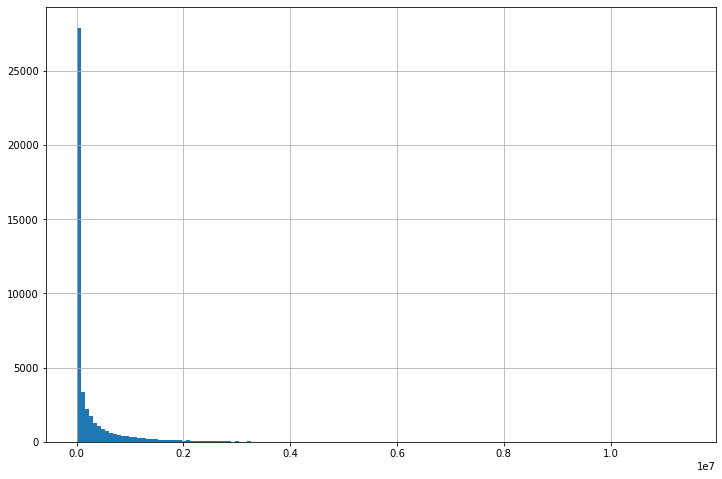

In [17]:
#Target Histogram
train_df['sellin'].hist(bins = 150)

# Feature Engineering

## Drop Null Features

In [18]:
train_df.drop('onhand_inventory_channel_6',inplace=True,axis=1)

## Constants

In [19]:
TRAIN_COLS = train_df.columns
TEST_COLS = test_df.columns

## Lags and Rolling Features

In [20]:
df = pd.concat([train_df,test_df])
df = df.sort_values(['sku_name','year','month']).reset_index(drop=True) 

Features = TRAIN_COLS
Features = Features.drop(['sku_name','month','year','product_lifecycle_stage','Weeks','CAT_GENDER_WOMEN','CAT_GENDER_MEN',
              'CAT_GENDER_BOTH'])

for feat in tqdm(Features):
    for window in [4,5,6,9,12]:
        df[f'{feat}_Lag_{window}'] = df.groupby('sku_name')[feat].shift(window)
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Lag_{window}')
        # The rolling was added to the lagged features instead of normal ones to avoid leakage
        df[f'{feat}_Rol_mean_{window}'] = df.groupby('sku_name')[feat].shift(4).rolling(window).mean().values
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_mean_{window}')
        df[f'{feat}_Rol_min_{window}'] = df.groupby('sku_name')[feat].shift(4).rolling(window).min().values
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_min_{window}')
        df[f'{feat}_Rol_max_{window}'] = df.groupby('sku_name')[feat].shift(4).rolling(window).max().values
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_max_{window}')
        df[f'{feat}_Rol_std_{window}'] = df.groupby('sku_name')[feat].shift(4).rolling(window).std().values
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_std_{window}')
        df[f'{feat}_Rol_sum_{window}'] = df.groupby('sku_name')[feat].shift(4).rolling(window).sum().values
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_sum_{window}')
        df[f'{feat}_Rol_range_{window}'] = df[f'{feat}_Rol_max_{window}'] - df[f'{feat}_Rol_min_{window}']
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_range_{window}')
        df[f'{feat}_Rol_qua25_{window}'] = df.groupby('sku_name')[feat].shift(4).rolling(window).quantile(0.25).values
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_qua25_{window}')
        df[f'{feat}_Rol_qua75_{window}'] = df.groupby('sku_name')[feat].shift(4).rolling(window).quantile(0.75).values
        TEST_COLS = TEST_COLS.insert(len(TEST_COLS)-1,f'{feat}_Rol_qua75_{window}')

df = reduce_memory_usage(df)
train_df = df[(((df['year'] < 2021)) | ((df['year'] == 2021) & ((df['month'] < 11))))]
test_df = df[((df['year'] == 2022) | ((df['year'] == 2021) & ((df['month'] >= 11))))]

#Drop Null Columns
test_df = test_df[TEST_COLS]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:38<00:00,  1.08s/it]


## Adding The Mean of The Different Channels

In [21]:
# 1     
features = [f'sellin_channel_{n}' for n in range(1,9)]
train_df[f"MEAN_{features[0]}"] = train_df[features].mean(axis=1)

# 2
features = [f'sellout_channel_{n}' for n in range(1,11)]
train_df[f"MEAN_{features[0]}"] = train_df[features].mean(axis=1)

# 3
features = [f'onhand_inventory_channel_{n}' for n in range(1,11)]
features.remove('onhand_inventory_channel_6')  # A null feature
train_df[f"MEAN_{features[0]}"] = train_df[features].mean(axis=1)

## Add Aggregated Features (Numerical)

In [22]:
def Agg(Feature):
    for dataset in (train_df,test_df):
        feats_1 = ['sku_name', 'month']
        for feat_1 in feats_1:
            dataset[f'{Feature}_Agg_{feat_1}_mean'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].mean()))
            dataset[f'{Feature}_Agg_{feat_1}_median'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].median()))
            dataset[f'{Feature}_Agg_{feat_1}_std'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].std()))
            dataset[f'{Feature}_Agg_{feat_1}_min'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].min()))
            dataset[f'{Feature}_Agg_{feat_1}_max'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].max()))
            dataset[f'{Feature}_Agg_{feat_1}_sum'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].sum()))
            dataset[f'{Feature}_Agg_{feat_1}_range'] = dataset[f'{Feature}_Agg_{feat_1}_max'] - dataset[f'{Feature}_Agg_{feat_1}_min']
            dataset[f'{Feature}_Agg_{feat_1}_skew'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].skew()))
            dataset[f'{Feature}_Agg_{feat_1}_first'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].first()))
            dataset[f'{Feature}_Agg_{feat_1}_last'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].last())) 
            for n in [0.25,0.75]:
                dataset[f'{Feature}_Agg_{feat_1}_quantile_{n}'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].quantile(n)))        

In [23]:
feats = TRAIN_COLS
feats = feats.drop(['sku_name','month','year','product_lifecycle_stage','Weeks','CAT_GENDER_WOMEN','CAT_GENDER_MEN',
              'CAT_GENDER_BOTH','FLAG100','disc_month','cum_disc','Weeks'])
for feat in tqdm(feats):
    Agg(feat)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:46<00:00,  3.24s/it]


## Add Aggregated Features (Categorical)

In [24]:
def Agg(Feature):
    for dataset in (train_df,test_df):
        for feat_1 in ['sku_name', 'month']:
            if Feature != 'product_lifecycle_stage':
                dataset[f'{Feature}_Agg_{feat_1}_mode'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].agg(lambda x: pd.Series.mode(x)[0])))
            dataset[f'{Feature}_Agg_{feat_1}_nunique'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].agg(pd.Series.nunique)))
            dataset[f'{Feature}_Agg_{feat_1}_count'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].agg(pd.Series.count)))
            dataset[f'{Feature}_Agg_{feat_1}_last'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].last()))

In [25]:
feats = ['product_lifecycle_stage','cum_disc','disc_month','FLAG100', 'Weeks']
for feat in tqdm(feats):
    Agg(feat)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.92s/it]


## Encoding

In [27]:
# Label Encoding
Target = train_df.sellin.copy()
train_df = train_df[test_df.columns]   # Use the features found on the test set only for training
train_df['sellin'] = Target.copy()
feats = list(train_df.select_dtypes(include=['object','category']).columns)
le = LabelEncoder()
df = pd.concat([train_df, test_df])
for f in feats:
    le.fit(df[f])
    train_df[f] = le.transform(train_df[f])
    test_df[f] = le.transform(test_df[f])

## Dropping Constants Features

In [28]:
for feat in tqdm(test_df.columns):
    if ((len(train_df[feat].value_counts().keys()) == 1) | (len(test_df[feat].value_counts().keys()) == 1)):
        train_df.drop(feat,inplace=True,axis=1)
        test_df.drop(feat,inplace=True,axis=1)
print('Columns After Dropping: ',len(train_df.columns))

100%|██████████████████████████████████████████████████████████████████████████████| 2456/2456 [01:22<00:00, 29.73it/s]

Columns After Dropping:  2217


## Some Modifications

In [29]:
cat_feats = ['sku_name','CAT_GENDER_MEN','CAT_GENDER_WOMEN','product_lifecycle_stage_Agg_sku_name_last']
train_df[['CAT_GENDER_MEN','CAT_GENDER_WOMEN']] = train_df[['CAT_GENDER_MEN','CAT_GENDER_WOMEN']].astype(int)
test_df[['CAT_GENDER_MEN','CAT_GENDER_WOMEN']] = test_df[['CAT_GENDER_MEN','CAT_GENDER_WOMEN']].astype(int)

# Modeling

In [30]:
cb_params = {'objective':'MAE','depth': 7, 'iterations': 211, 'learning_rate': 0.1, 'verbose': 1,
             'task_type': 'CPU','od_type':'Iter','od_wait': 200}
cb = CatBoostRegressor(**cb_params, random_state=42)

## Inference

0:	learn: 231771.9884327	total: 1.15s	remaining: 4m 1s
1:	learn: 223126.8947107	total: 1.89s	remaining: 3m 17s
2:	learn: 214888.2772403	total: 2.67s	remaining: 3m 4s
3:	learn: 209010.6139936	total: 3.4s	remaining: 2m 55s
4:	learn: 202152.5990127	total: 4.13s	remaining: 2m 50s
5:	learn: 196395.4989001	total: 4.93s	remaining: 2m 48s
6:	learn: 191343.1415889	total: 5.67s	remaining: 2m 45s
7:	learn: 187054.3375553	total: 6.39s	remaining: 2m 42s
8:	learn: 182701.7289633	total: 7.1s	remaining: 2m 39s
9:	learn: 179305.8761632	total: 7.82s	remaining: 2m 37s
10:	learn: 175339.0690284	total: 8.5s	remaining: 2m 34s
11:	learn: 171639.8261365	total: 9.23s	remaining: 2m 33s
12:	learn: 169166.3327021	total: 9.93s	remaining: 2m 31s
13:	learn: 166231.8828805	total: 10.7s	remaining: 2m 30s
14:	learn: 163086.6784710	total: 11.4s	remaining: 2m 28s
15:	learn: 160491.1757466	total: 12.2s	remaining: 2m 28s
16:	learn: 158113.8135197	total: 12.9s	remaining: 2m 27s
17:	learn: 156048.6046622	total: 13.6s	remaini

144:	learn: 120874.7116365	total: 1m 45s	remaining: 47.8s
145:	learn: 120592.5603380	total: 1m 45s	remaining: 47s
146:	learn: 120456.4460520	total: 1m 46s	remaining: 46.3s
147:	learn: 120356.7131049	total: 1m 47s	remaining: 45.6s
148:	learn: 120148.3520232	total: 1m 47s	remaining: 44.8s
149:	learn: 120147.8910986	total: 1m 48s	remaining: 44.1s
150:	learn: 120095.7221068	total: 1m 49s	remaining: 43.4s
151:	learn: 120086.4398673	total: 1m 49s	remaining: 42.6s
152:	learn: 120085.9450646	total: 1m 50s	remaining: 41.9s
153:	learn: 119968.9051056	total: 1m 51s	remaining: 41.2s
154:	learn: 119875.9026678	total: 1m 51s	remaining: 40.4s
155:	learn: 119683.4095529	total: 1m 52s	remaining: 39.7s
156:	learn: 119579.2391829	total: 1m 53s	remaining: 39s
157:	learn: 119141.8816546	total: 1m 54s	remaining: 38.3s
158:	learn: 118963.0083448	total: 1m 54s	remaining: 37.6s
159:	learn: 118894.9023180	total: 1m 55s	remaining: 36.8s
160:	learn: 118708.6123201	total: 1m 56s	remaining: 36.1s
161:	learn: 118620

<AxesSubplot:>

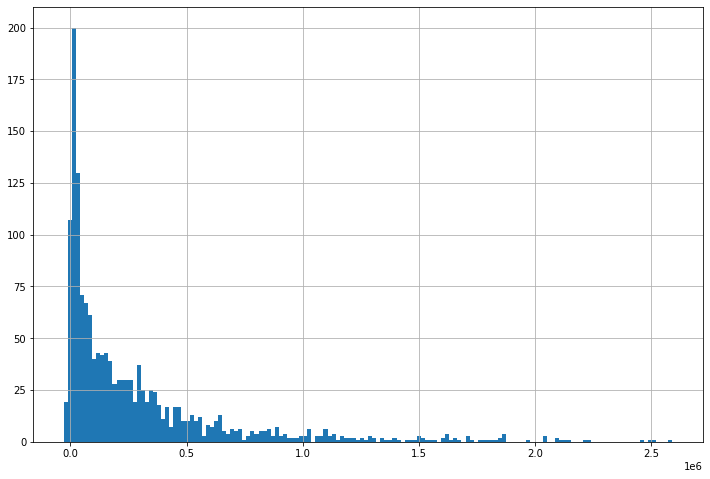

In [31]:
X = train_df.drop('sellin',axis=1)
y = train_df['sellin'] 
cb.fit(X,y, cat_features=cat_feats)
Predictions = cb.predict(test_df)
submission = pd.DataFrame({"Item_ID": ID.values ,"Target": Predictions})
submission.to_csv('FinalSubmission.csv',index=False)
submission['Target'].hist(bins=150)

## Show the Features Importance 

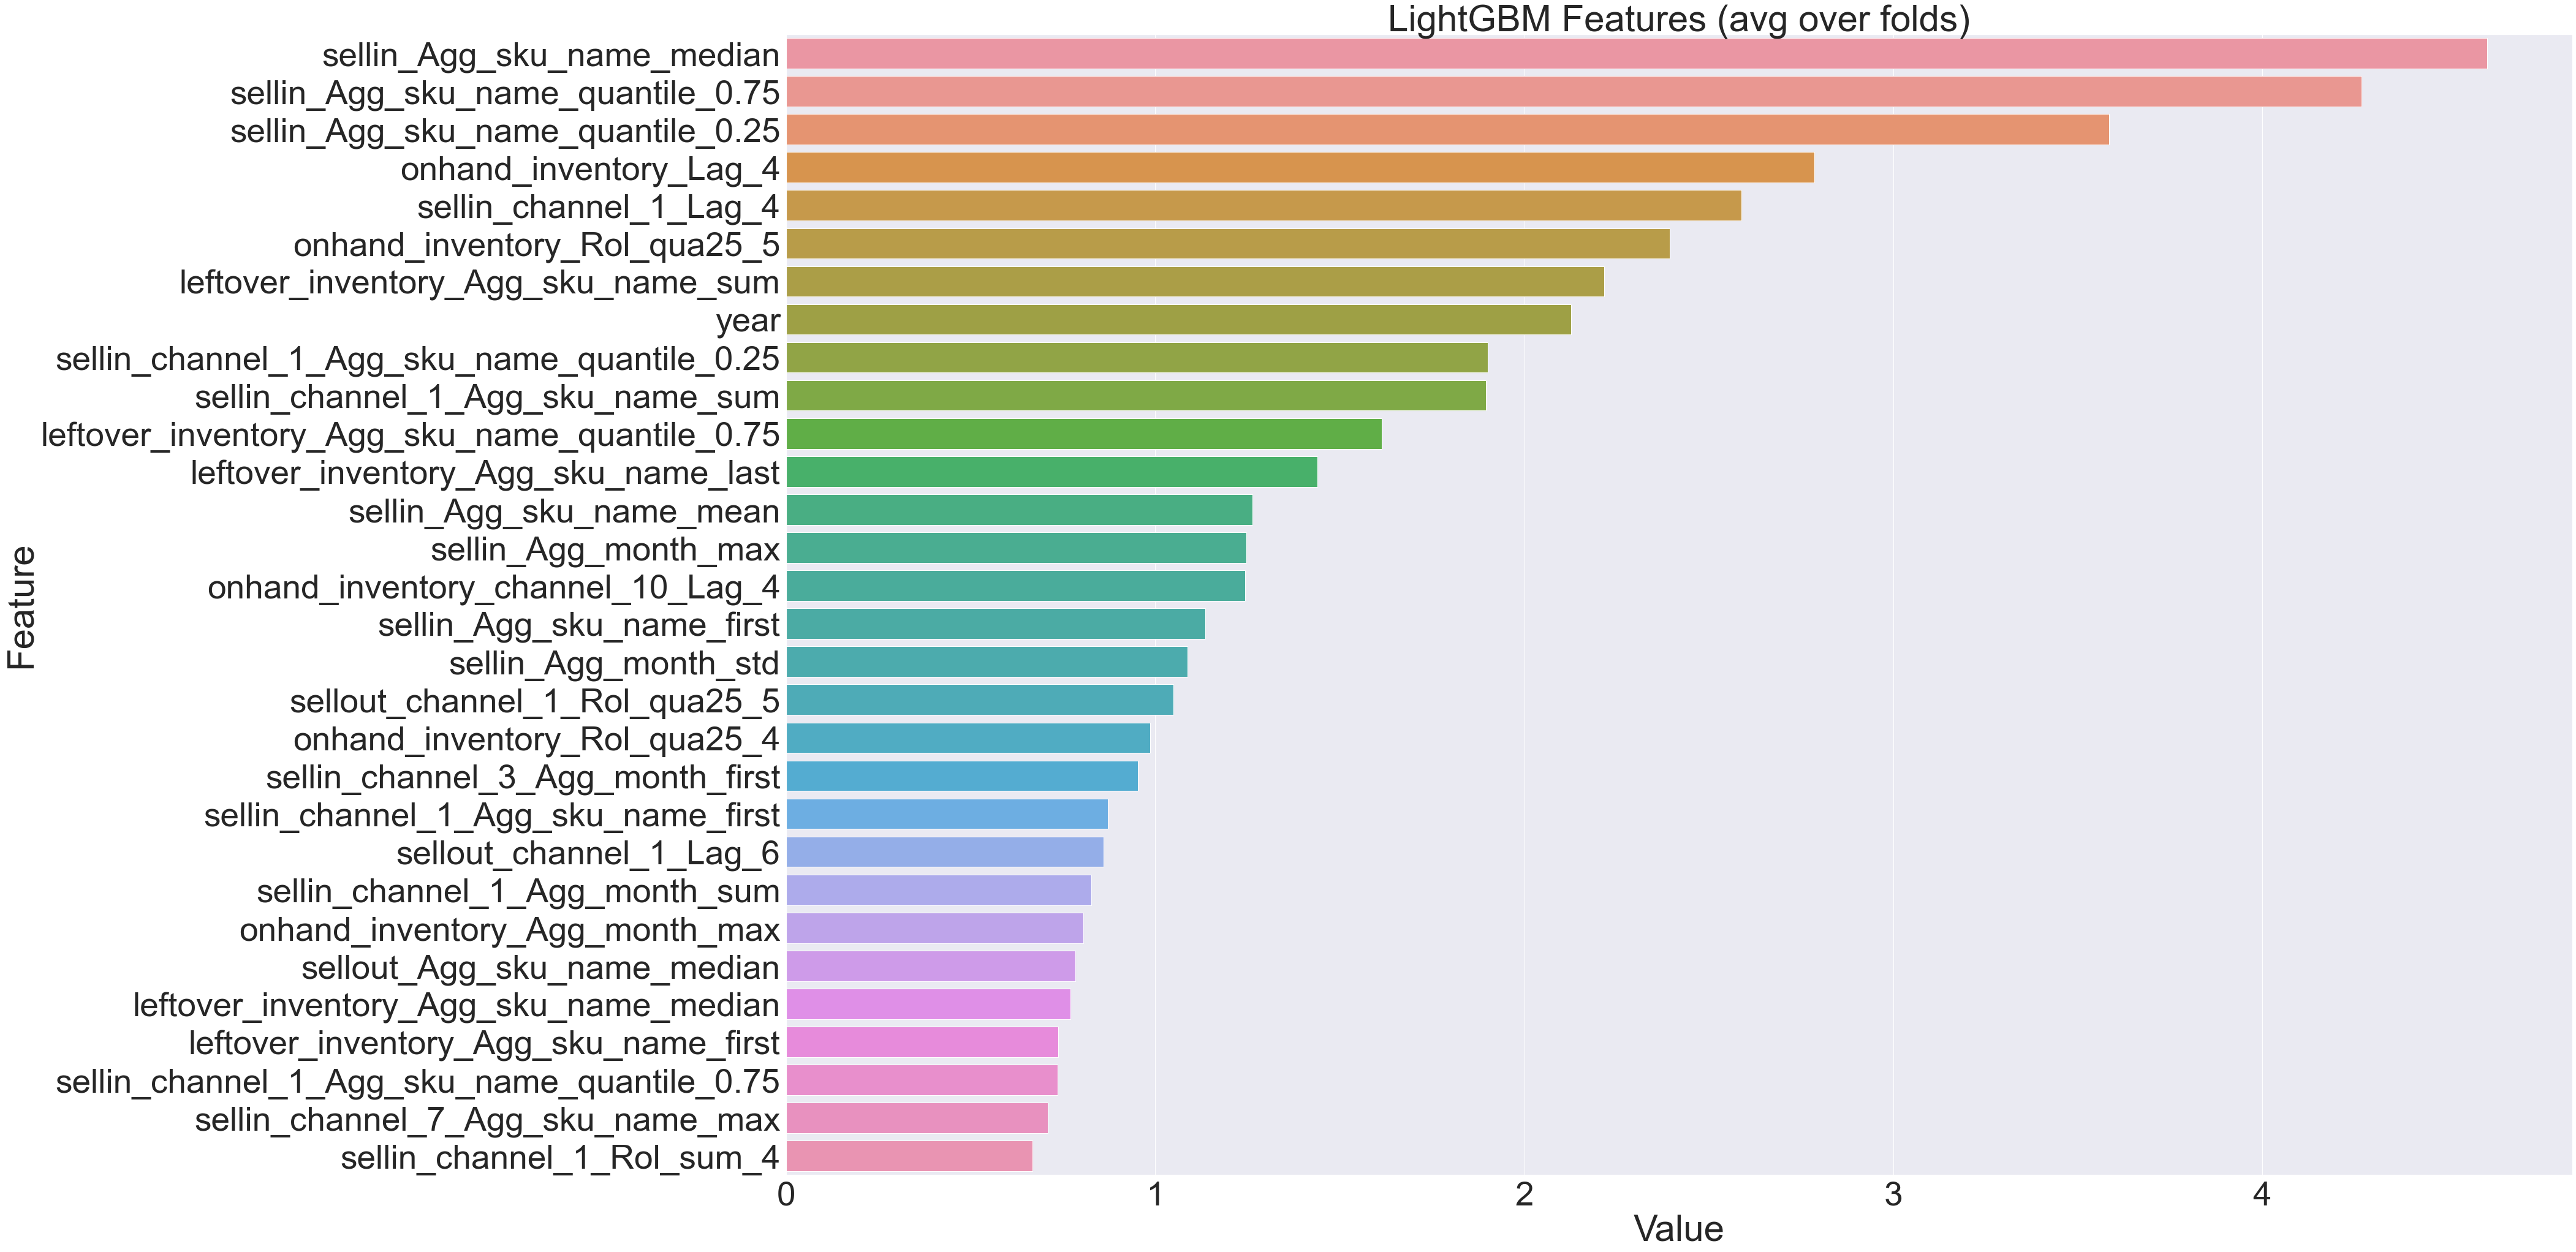

In [32]:
plotImp(cb,train_df.drop('sellin',axis=1))